In [1]:
import cv2
import numpy as np
from utils import read_rgb, read_bw, show_im

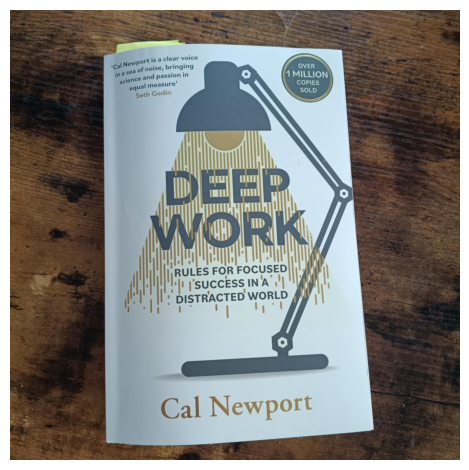

In [2]:
book1 = read_rgb('book1.jpeg')

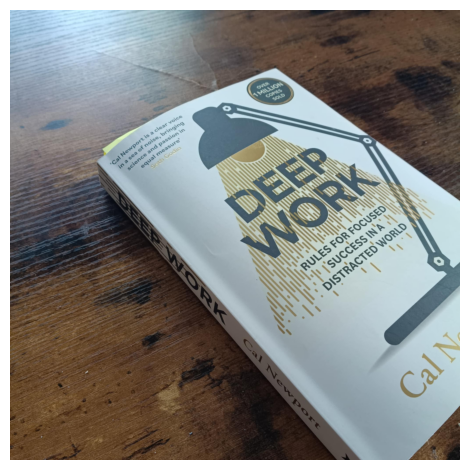

In [3]:
book2 = read_rgb('book2.jpeg')

Found 8246 keypoints
Found 11939 keypoints


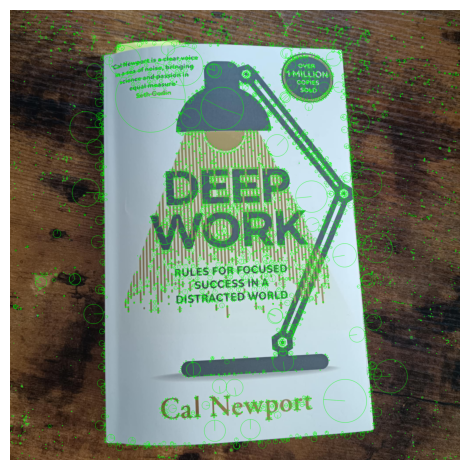

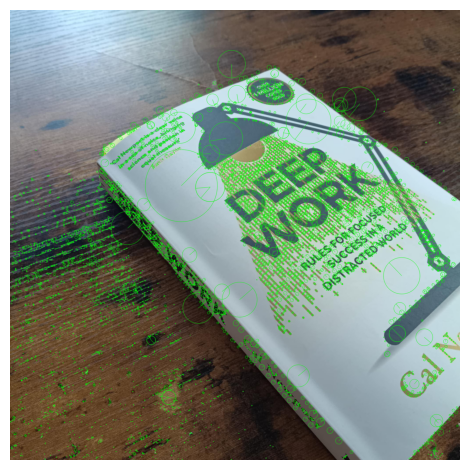

In [14]:
def show_blobs(image):
    blobs = cv2.SIFT_create(contrastThreshold=0.05, edgeThreshold=50).detect(image, None)
    print(f'Found {len(blobs)} keypoints')
    book1_blobs = cv2.drawKeypoints(image, blobs, None, color=(0, 255, 0),
                                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    show_im(book1_blobs)

show_blobs(book1)
show_blobs(book2)

Found 9559 matches
Selected 138 matches


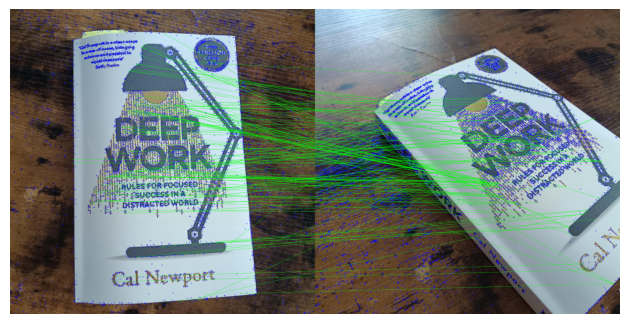

In [23]:
sift = cv2.SIFT_create(contrastThreshold=0.05, edgeThreshold=50)
sift = cv2.SIFT_create(contrastThreshold=0.05, edgeThreshold=100)
book1_blobs, book1_desc = sift.detectAndCompute(book1, mask=None)
book2_blobs, book2_desc = sift.detectAndCompute(book2, mask=None)

matcher = cv2.BFMatcher_create() # Brute Force Matcher
best_k_matches = matcher.knnMatch(book1_desc, book2_desc, k=2)
print(f'Found {len(best_k_matches)} matches')

best_matches = []
for m, n in best_k_matches:
    if m.distance > 0.75 * n.distance:
        continue # Lowe ratio test - ensure best match is significantly better than second best
    if m.distance > 50:
        continue # filter out matches with large distance
    best_matches.append(m)
print(f'Selected {len(best_matches)} matches')

show_matches = cv2.drawMatches(book1, book1_blobs,
                               book2, book2_blobs,
                               best_matches, None,
                               matchColor=(0,255,0),
                               singlePointColor=(0,0,255))
show_im(show_matches)

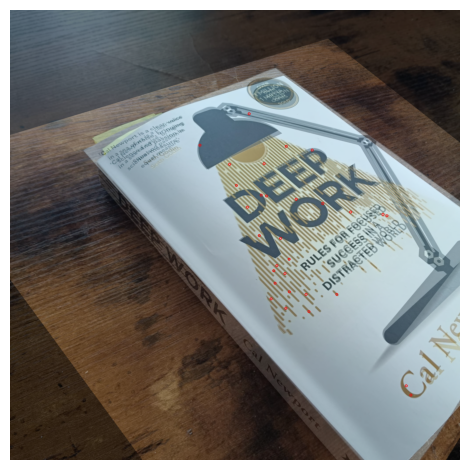

In [24]:
src_points = np.float32([book1_blobs[m.queryIdx].pt for m in best_matches]).reshape(-1, 1, 2)
dst_points = np.float32([book2_blobs[m.trainIdx].pt for m in best_matches]).reshape(-1, 1, 2)

matrix, _ = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
img1_trans = cv2.warpPerspective(book1, matrix, dsize=(book2.shape[1], book2.shape[0]))
src_points_trans = cv2.perspectiveTransform(src_points, matrix)

alpha = 0.5
blended_image = cv2.addWeighted(img1_trans, alpha, book2, 1 - alpha, 0)
for src_trans, dst in zip(src_points_trans, dst_points):
    if np.linalg.norm(dst[0] - src_trans[0]) < 50:
        cv2.circle(blended_image, (int(src_trans[0][0]), int(src_trans[0][1])), 5, (255, 0, 0), 2)

show_im(blended_image)